### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:0


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/torch_sm/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/images/*')
train_labels = glob.glob('/data/segmentation/CVC-ClinicDB/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/CVC-ClinicDB/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 366 elements
My custom valing-dataset has 123 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

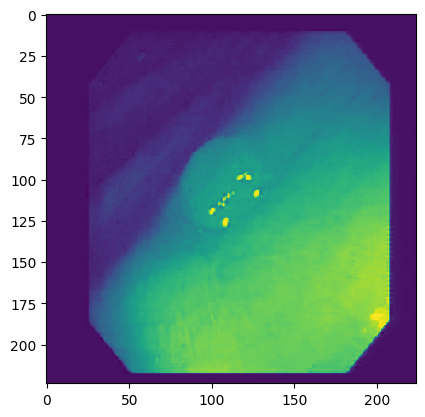

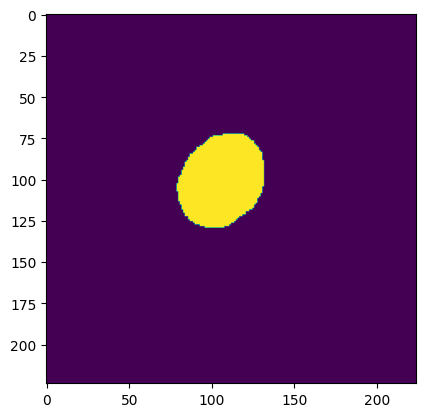

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [5]:
# Begin training
from models.pop_seg_models.FCN.models.segmentation.fcn import fcn_resnet101

model = fcn_resnet101(num_classes = 1)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [13]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [14]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'FCN'
data_name = 'CVC'

# 5. Training

 Epoch: 1 of 100, Iter.: 46 of 46, Train Loss: 0.985585, IoU: 0.406592, Dice: 0.519442
 Epoch: 1 of 100, Iter.: 46 of 46, Valid Loss: 0.678581, IoU: 0.517115, Dice: 0.644336

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


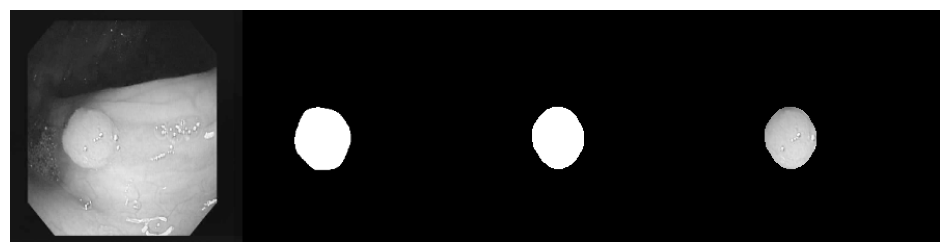

 Epoch: 2 of 100, Iter.: 46 of 46, Train Loss: 0.445543, IoU: 0.671004, Dice: 0.775188
 Epoch: 2 of 100, Iter.: 46 of 46, Valid Loss: 0.463245, IoU: 0.571027, Dice: 0.674263


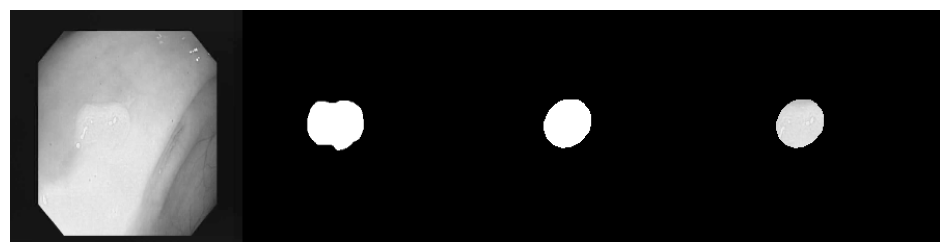

 Epoch: 3 of 100, Iter.: 46 of 46, Train Loss: 0.293767, IoU: 0.756555, Dice: 0.839069
 Epoch: 3 of 100, Iter.: 46 of 46, Valid Loss: 0.355437, IoU: 0.693278, Dice: 0.783658


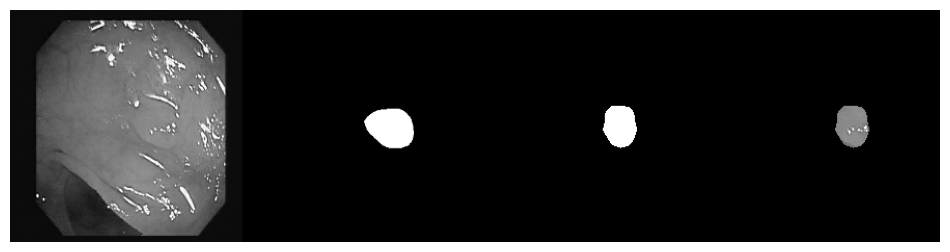

 Epoch: 4 of 100, Iter.: 46 of 46, Train Loss: 0.209953, IoU: 0.805279, Dice: 0.874442
 Epoch: 4 of 100, Iter.: 46 of 46, Valid Loss: 0.299629, IoU: 0.727811, Dice: 0.809932


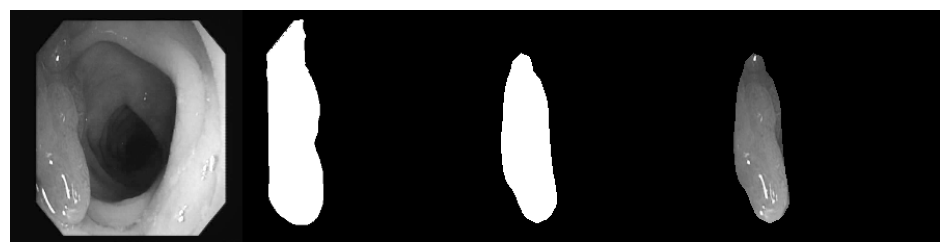

 Epoch: 5 of 100, Iter.: 46 of 46, Train Loss: 0.173114, IoU: 0.822076, Dice: 0.887663
 Epoch: 5 of 100, Iter.: 46 of 46, Valid Loss: 0.267893, IoU: 0.744414, Dice: 0.825593


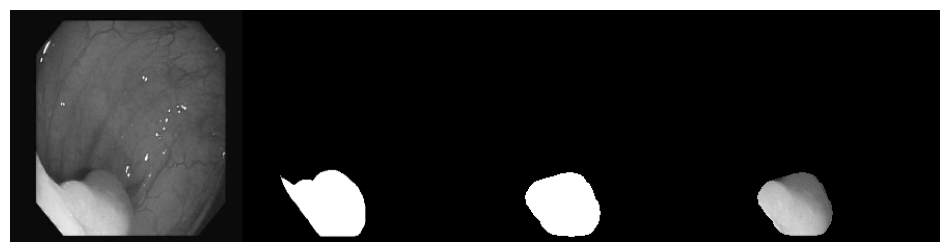

 Epoch: 6 of 100, Iter.: 46 of 46, Train Loss: 0.149045, IoU: 0.837693, Dice: 0.895934
 Epoch: 6 of 100, Iter.: 46 of 46, Valid Loss: 0.232629, IoU: 0.746498, Dice: 0.824654


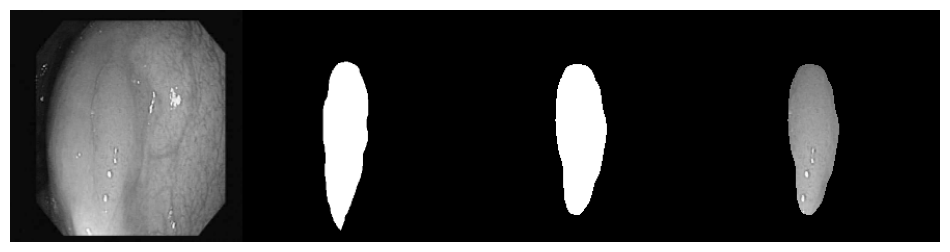

 Epoch: 7 of 100, Iter.: 46 of 46, Train Loss: 0.135482, IoU: 0.847104, Dice: 0.905019
 Epoch: 7 of 100, Iter.: 46 of 46, Valid Loss: 0.270951, IoU: 0.734307, Dice: 0.817402


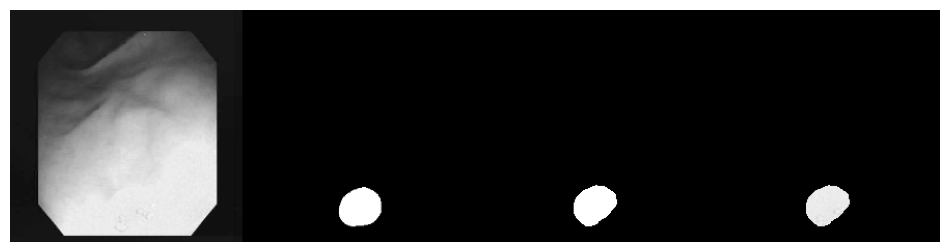

 Epoch: 8 of 100, Iter.: 46 of 46, Train Loss: 0.106880, IoU: 0.869571, Dice: 0.919164
 Epoch: 8 of 100, Iter.: 46 of 46, Valid Loss: 0.217689, IoU: 0.768537, Dice: 0.843997


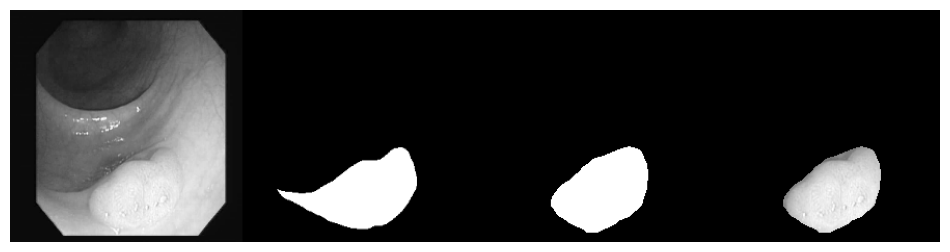

 Epoch: 9 of 100, Iter.: 46 of 46, Train Loss: 0.093382, IoU: 0.879239, Dice: 0.924328
 Epoch: 9 of 100, Iter.: 46 of 46, Valid Loss: 0.219437, IoU: 0.771381, Dice: 0.845562


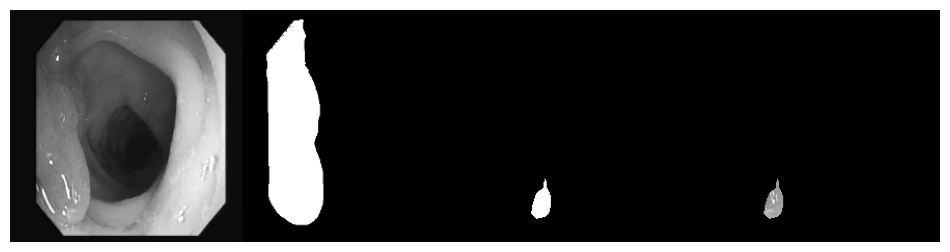

 Epoch: 10 of 100, Iter.: 46 of 46, Train Loss: 0.086808, IoU: 0.886894, Dice: 0.930619
 Epoch: 10 of 100, Iter.: 46 of 46, Valid Loss: 0.187378, IoU: 0.791151, Dice: 0.861548


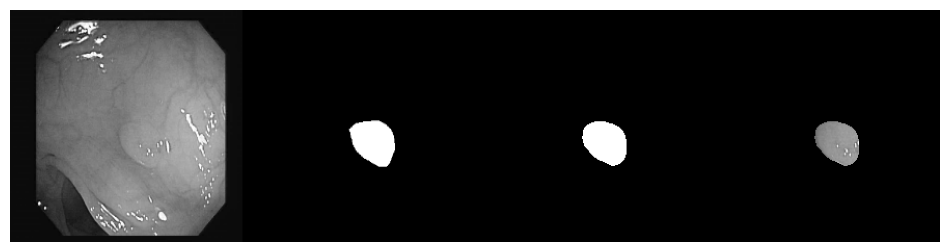

 Epoch: 11 of 100, Iter.: 46 of 46, Train Loss: 0.073828, IoU: 0.903265, Dice: 0.941497
 Epoch: 11 of 100, Iter.: 46 of 46, Valid Loss: 0.186253, IoU: 0.788096, Dice: 0.859684


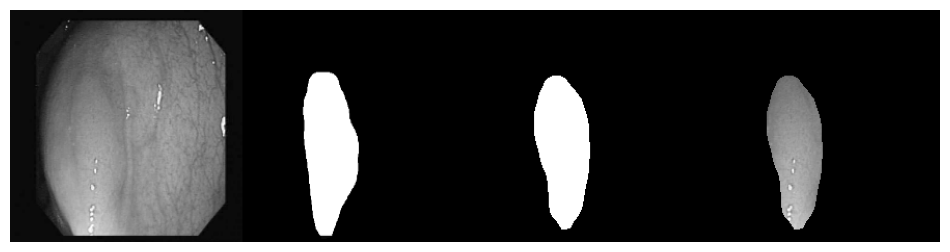

 Epoch: 12 of 100, Iter.: 46 of 46, Train Loss: 0.067572, IoU: 0.910162, Dice: 0.946226
 Epoch: 12 of 100, Iter.: 46 of 46, Valid Loss: 0.175321, IoU: 0.800945, Dice: 0.869458


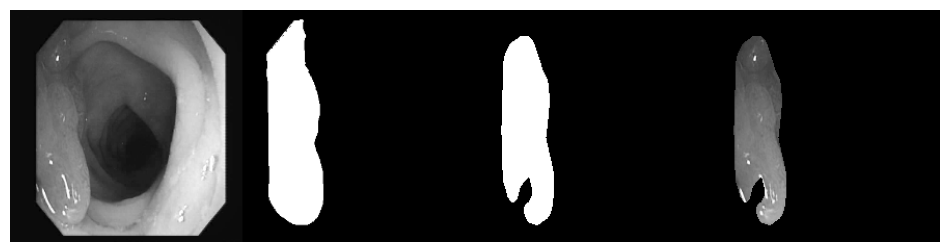

 Epoch: 13 of 100, Iter.: 46 of 46, Train Loss: 0.061124, IoU: 0.917802, Dice: 0.952413
 Epoch: 13 of 100, Iter.: 46 of 46, Valid Loss: 0.186312, IoU: 0.797903, Dice: 0.868953


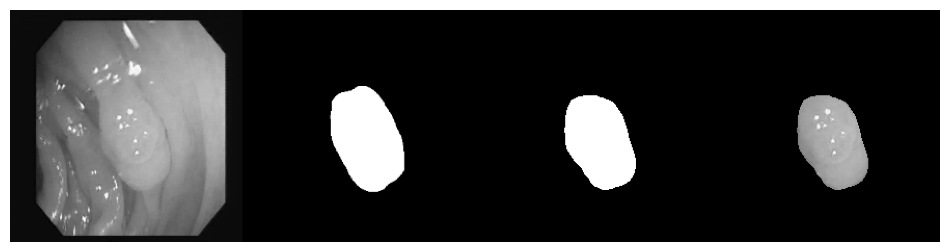

 Epoch: 14 of 100, Iter.: 46 of 46, Train Loss: 0.056092, IoU: 0.924125, Dice: 0.955849
 Epoch: 14 of 100, Iter.: 46 of 46, Valid Loss: 0.177489, IoU: 0.801321, Dice: 0.870014


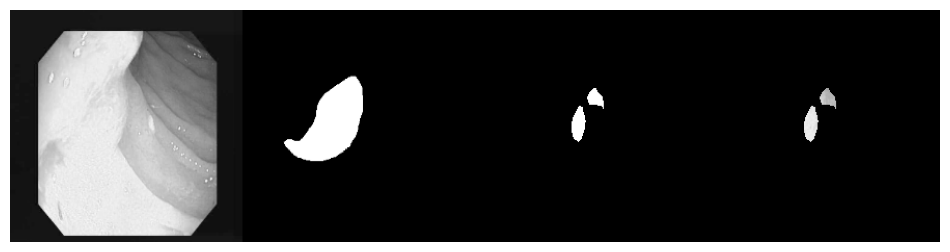

 Epoch: 15 of 100, Iter.: 46 of 46, Train Loss: 0.052542, IoU: 0.926679, Dice: 0.957182
 Epoch: 15 of 100, Iter.: 46 of 46, Valid Loss: 0.170375, IoU: 0.808089, Dice: 0.875642


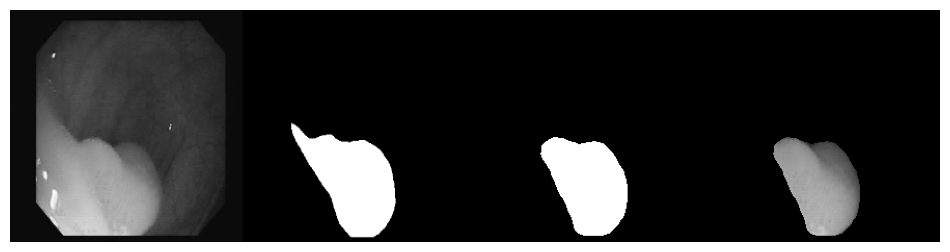

 Epoch: 16 of 100, Iter.: 46 of 46, Train Loss: 0.051098, IoU: 0.932076, Dice: 0.963043
 Epoch: 16 of 100, Iter.: 46 of 46, Valid Loss: 0.178984, IoU: 0.803904, Dice: 0.871478


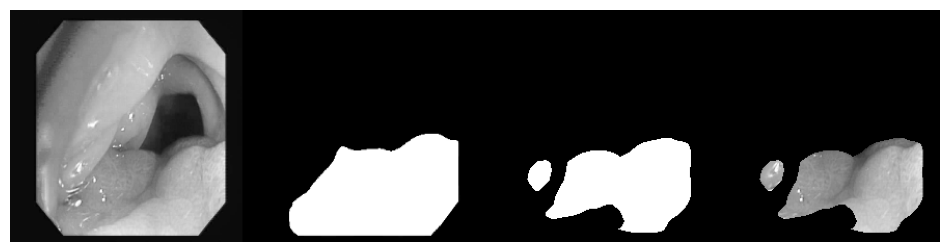

 Epoch: 17 of 100, Iter.: 46 of 46, Train Loss: 0.049233, IoU: 0.934195, Dice: 0.964038
 Epoch: 17 of 100, Iter.: 46 of 46, Valid Loss: 0.177471, IoU: 0.800122, Dice: 0.868160


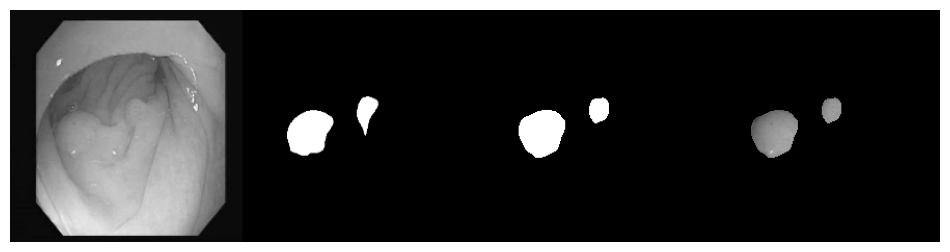

 Epoch: 18 of 100, Iter.: 46 of 46, Train Loss: 0.046123, IoU: 0.937383, Dice: 0.965880
 Epoch: 18 of 100, Iter.: 46 of 46, Valid Loss: 0.168733, IoU: 0.812322, Dice: 0.878724


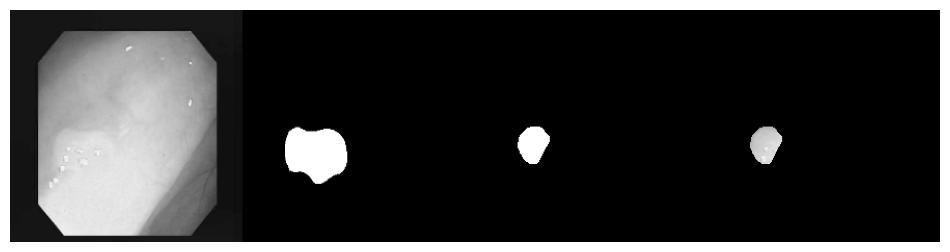

 Epoch: 19 of 100, Iter.: 46 of 46, Train Loss: 0.042705, IoU: 0.941435, Dice: 0.968429
 Epoch: 19 of 100, Iter.: 46 of 46, Valid Loss: 0.174710, IoU: 0.806002, Dice: 0.872855


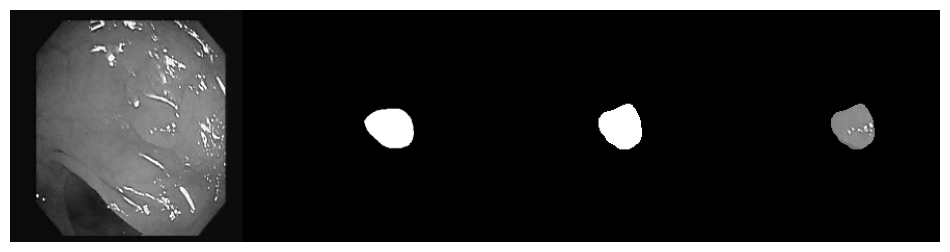

 Epoch: 20 of 100, Iter.: 46 of 46, Train Loss: 0.041518, IoU: 0.941875, Dice: 0.968427
 Epoch: 20 of 100, Iter.: 46 of 46, Valid Loss: 0.181612, IoU: 0.807054, Dice: 0.875166


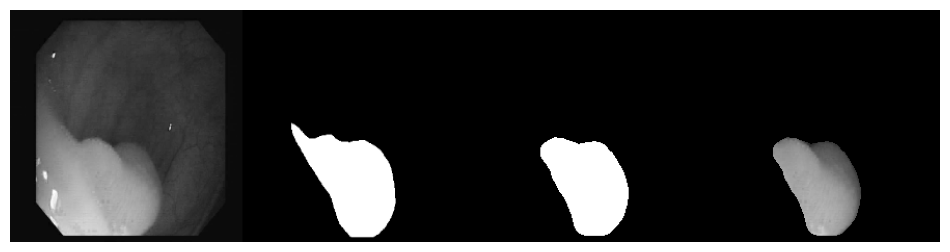

 Epoch: 21 of 100, Iter.: 46 of 46, Train Loss: 0.040291, IoU: 0.944603, Dice: 0.970629
 Epoch: 21 of 100, Iter.: 46 of 46, Valid Loss: 0.179487, IoU: 0.810320, Dice: 0.877272


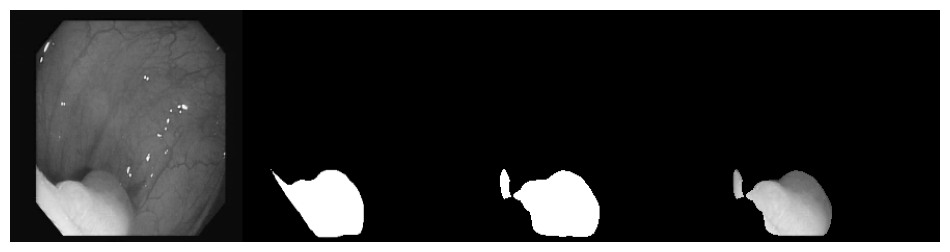

 Epoch: 22 of 100, Iter.: 46 of 46, Train Loss: 0.037688, IoU: 0.946597, Dice: 0.971574
 Epoch: 22 of 100, Iter.: 46 of 46, Valid Loss: 0.183356, IoU: 0.810454, Dice: 0.877148


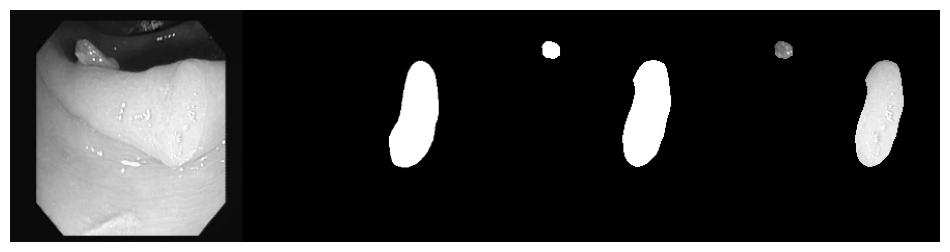

 Epoch: 23 of 100, Iter.: 46 of 46, Train Loss: 0.036158, IoU: 0.949215, Dice: 0.973268
 Epoch: 23 of 100, Iter.: 46 of 46, Valid Loss: 0.177446, IoU: 0.810790, Dice: 0.877661


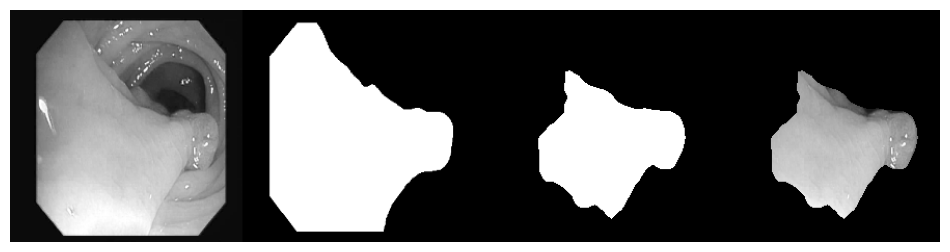

 Epoch: 24 of 100, Iter.: 46 of 46, Train Loss: 0.035203, IoU: 0.951911, Dice: 0.974878
 Epoch: 24 of 100, Iter.: 46 of 46, Valid Loss: 0.190388, IoU: 0.808625, Dice: 0.876304


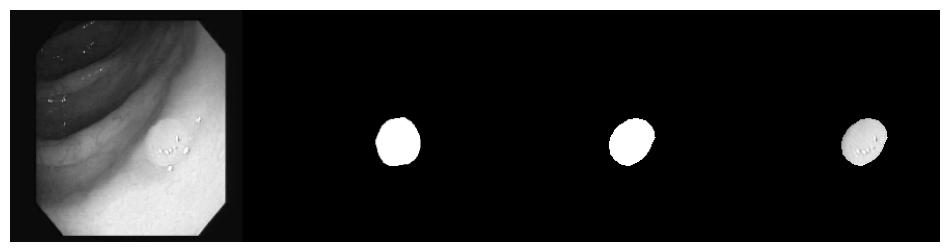

 Epoch: 25 of 100, Iter.: 46 of 46, Train Loss: 0.035177, IoU: 0.950368, Dice: 0.974003
 Epoch: 25 of 100, Iter.: 46 of 46, Valid Loss: 0.197854, IoU: 0.796744, Dice: 0.868390


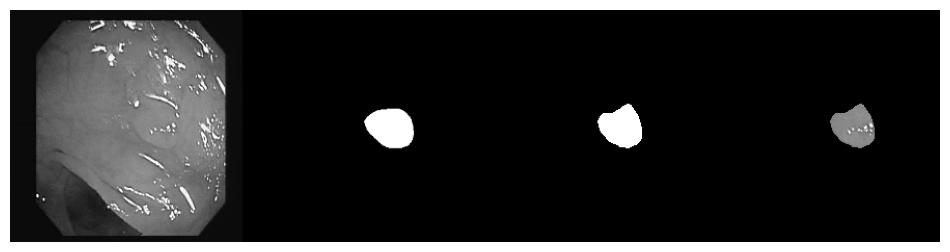

 Epoch: 26 of 100, Iter.: 46 of 46, Train Loss: 0.036018, IoU: 0.950062, Dice: 0.973870
 Epoch: 26 of 100, Iter.: 46 of 46, Valid Loss: 0.194478, IoU: 0.803853, Dice: 0.872453


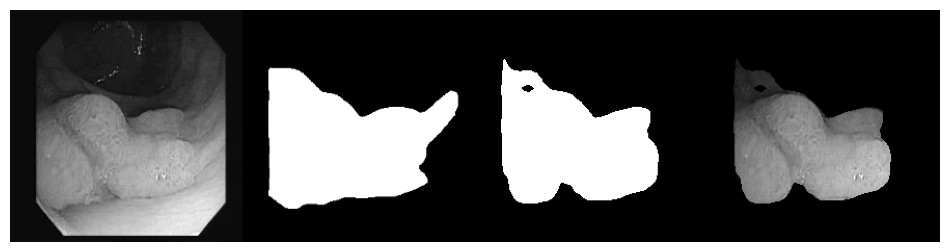

 Epoch: 27 of 100, Iter.: 46 of 46, Train Loss: 0.033201, IoU: 0.951044, Dice: 0.973127
 Epoch: 27 of 100, Iter.: 46 of 46, Valid Loss: 0.183853, IoU: 0.815803, Dice: 0.881479


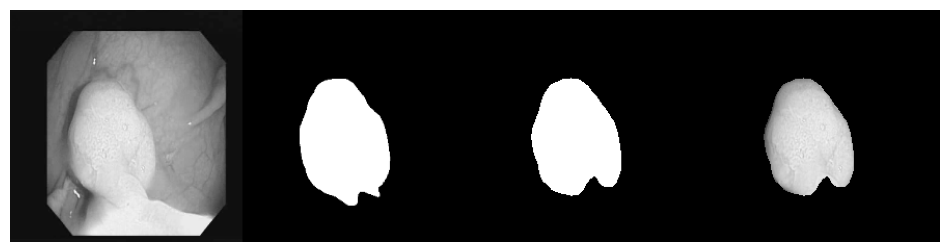

 Epoch: 28 of 100, Iter.: 46 of 46, Train Loss: 0.030781, IoU: 0.955942, Dice: 0.976708
 Epoch: 28 of 100, Iter.: 46 of 46, Valid Loss: 0.189747, IoU: 0.812584, Dice: 0.879509


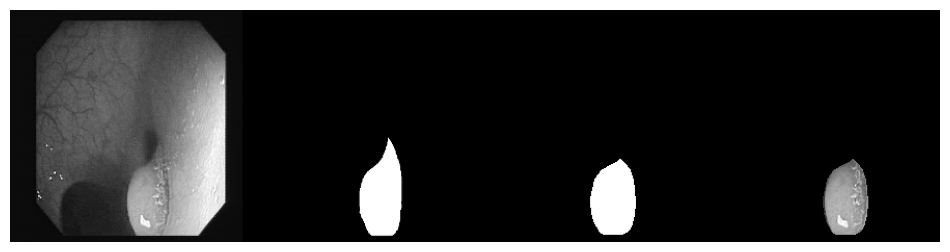

 Epoch: 29 of 100, Iter.: 46 of 46, Train Loss: 0.030837, IoU: 0.956690, Dice: 0.977305
 Epoch: 29 of 100, Iter.: 46 of 46, Valid Loss: 0.188451, IoU: 0.814064, Dice: 0.880956


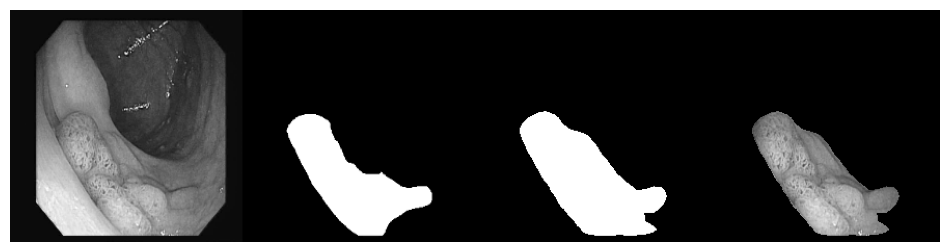

 Epoch: 30 of 100, Iter.: 46 of 46, Train Loss: 0.030605, IoU: 0.955288, Dice: 0.976735
 Epoch: 30 of 100, Iter.: 46 of 46, Valid Loss: 0.192449, IoU: 0.816627, Dice: 0.880920


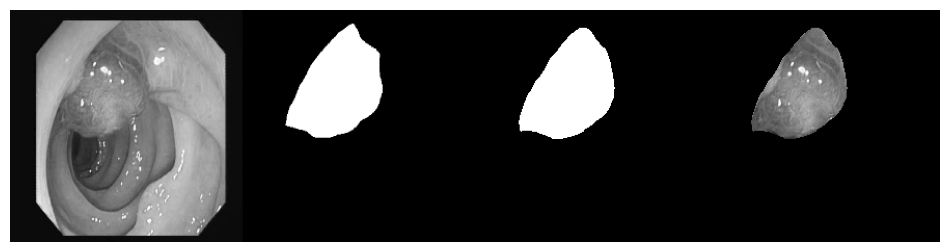

 Epoch: 31 of 100, Iter.: 46 of 46, Train Loss: 0.028464, IoU: 0.958899, Dice: 0.978676
 Epoch: 31 of 100, Iter.: 46 of 46, Valid Loss: 0.192462, IoU: 0.810084, Dice: 0.875955


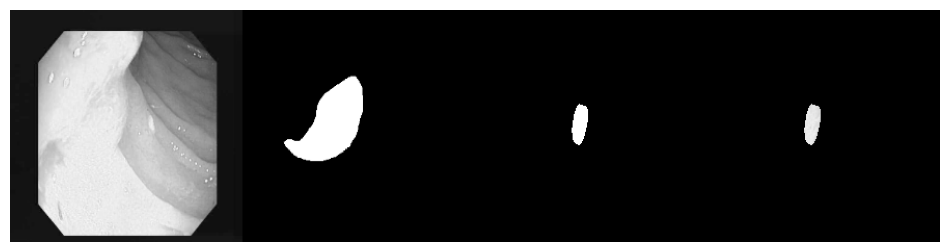

 Epoch: 32 of 100, Iter.: 46 of 46, Train Loss: 0.027781, IoU: 0.960513, Dice: 0.979541
 Epoch: 32 of 100, Iter.: 46 of 46, Valid Loss: 0.186770, IoU: 0.816017, Dice: 0.881972


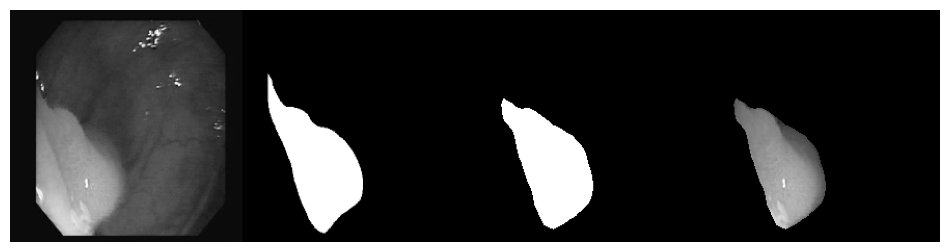

 Epoch: 33 of 100, Iter.: 46 of 46, Train Loss: 0.026096, IoU: 0.962432, Dice: 0.980568
 Epoch: 33 of 100, Iter.: 46 of 46, Valid Loss: 0.198676, IoU: 0.814795, Dice: 0.881295


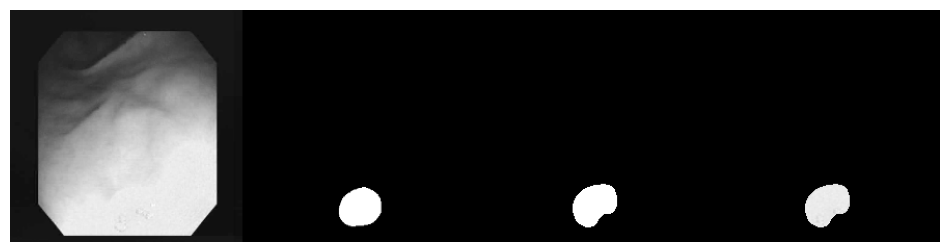

 Epoch: 34 of 100, Iter.: 46 of 46, Train Loss: 0.026488, IoU: 0.961062, Dice: 0.979804
 Epoch: 34 of 100, Iter.: 46 of 46, Valid Loss: 0.200721, IoU: 0.811354, Dice: 0.877458


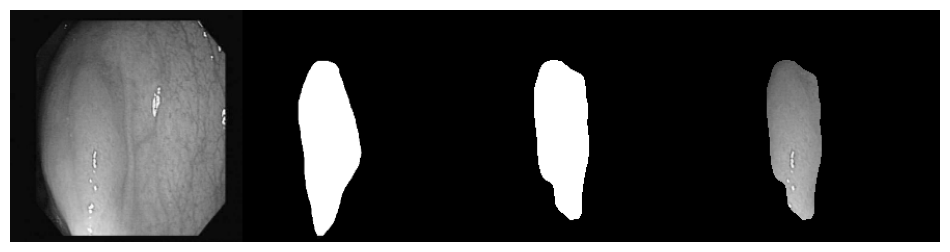

 Epoch: 35 of 100, Iter.: 46 of 46, Train Loss: 0.025673, IoU: 0.963641, Dice: 0.981287
 Epoch: 35 of 100, Iter.: 46 of 46, Valid Loss: 0.200568, IoU: 0.815035, Dice: 0.881943


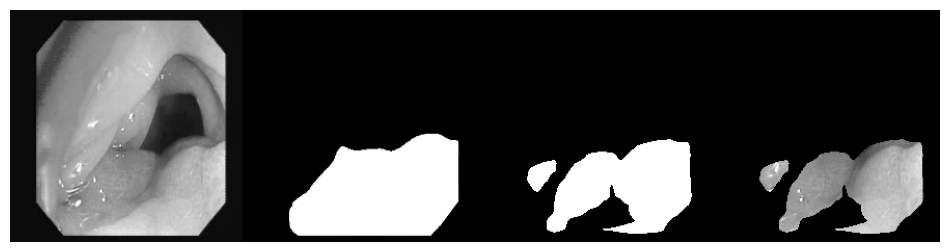

 Epoch: 36 of 100, Iter.: 46 of 46, Train Loss: 0.024262, IoU: 0.964865, Dice: 0.981914
 Epoch: 36 of 100, Iter.: 46 of 46, Valid Loss: 0.200933, IoU: 0.814073, Dice: 0.879946


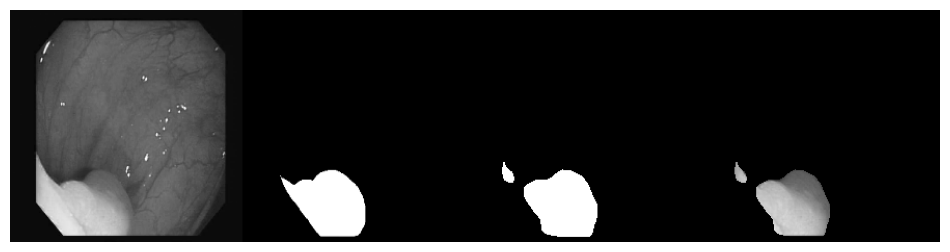

 Epoch: 37 of 100, Iter.: 46 of 46, Train Loss: 0.023158, IoU: 0.967547, Dice: 0.983332
 Epoch: 37 of 100, Iter.: 46 of 46, Valid Loss: 0.194490, IoU: 0.816373, Dice: 0.881798


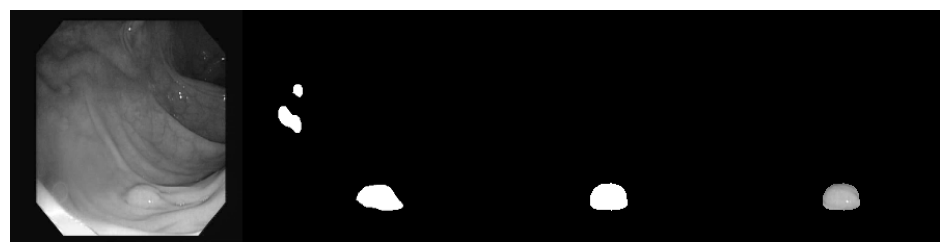

 Epoch: 38 of 100, Iter.: 46 of 46, Train Loss: 0.022659, IoU: 0.968031, Dice: 0.983588
 Epoch: 38 of 100, Iter.: 46 of 46, Valid Loss: 0.202667, IoU: 0.819828, Dice: 0.885031


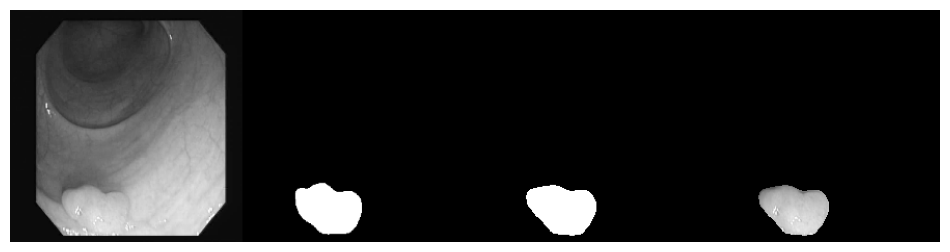

 Epoch: 39 of 100, Iter.: 46 of 46, Train Loss: 0.022788, IoU: 0.968420, Dice: 0.983825
 Epoch: 39 of 100, Iter.: 46 of 46, Valid Loss: 0.202394, IoU: 0.814883, Dice: 0.879430


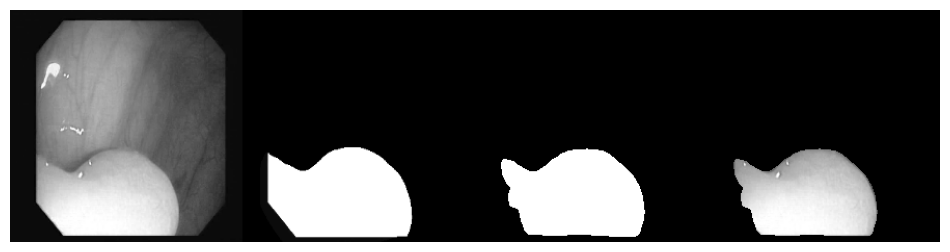

 Epoch: 40 of 100, Iter.: 46 of 46, Train Loss: 0.022860, IoU: 0.966983, Dice: 0.983065
 Epoch: 40 of 100, Iter.: 46 of 46, Valid Loss: 0.201246, IoU: 0.813679, Dice: 0.878483


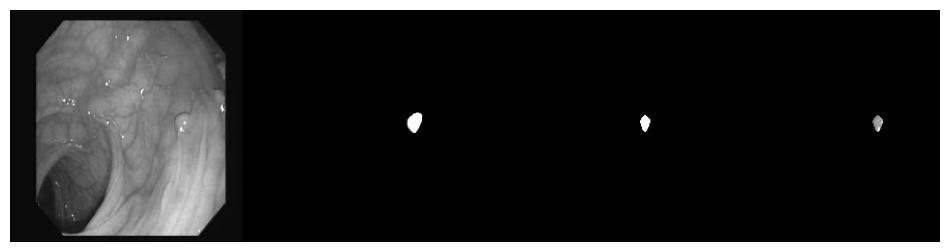

 Epoch: 41 of 100, Iter.: 46 of 46, Train Loss: 0.022914, IoU: 0.967492, Dice: 0.983327
 Epoch: 41 of 100, Iter.: 46 of 46, Valid Loss: 0.199132, IoU: 0.820485, Dice: 0.885483


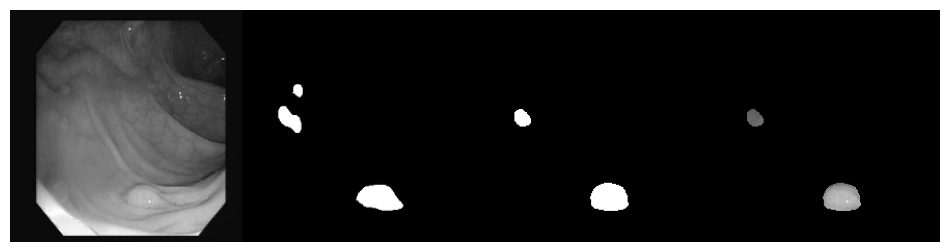

 Epoch: 42 of 100, Iter.: 46 of 46, Train Loss: 0.021770, IoU: 0.968166, Dice: 0.983657
 Epoch: 42 of 100, Iter.: 46 of 46, Valid Loss: 0.209366, IoU: 0.818823, Dice: 0.884080


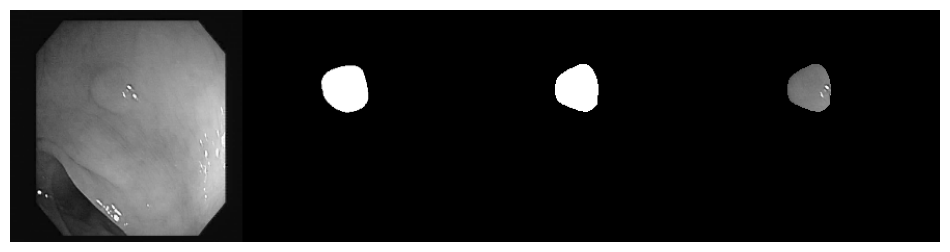

 Epoch: 43 of 100, Iter.: 46 of 46, Train Loss: 0.021177, IoU: 0.969536, Dice: 0.984343
 Epoch: 43 of 100, Iter.: 46 of 46, Valid Loss: 0.204640, IoU: 0.816109, Dice: 0.882594


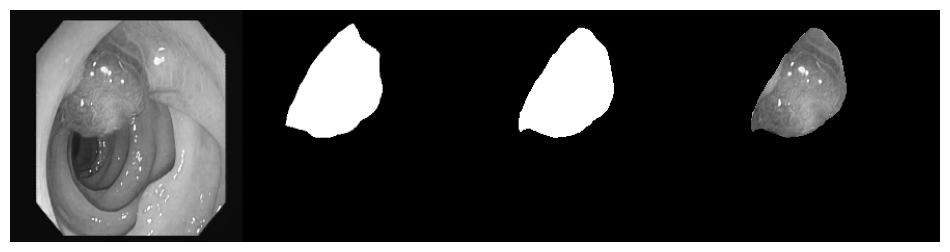

 Epoch: 44 of 100, Iter.: 46 of 46, Train Loss: 0.284788, IoU: 0.781888, Dice: 0.846180
 Epoch: 44 of 100, Iter.: 46 of 46, Valid Loss: 0.860778, IoU: 0.251152, Dice: 0.314711


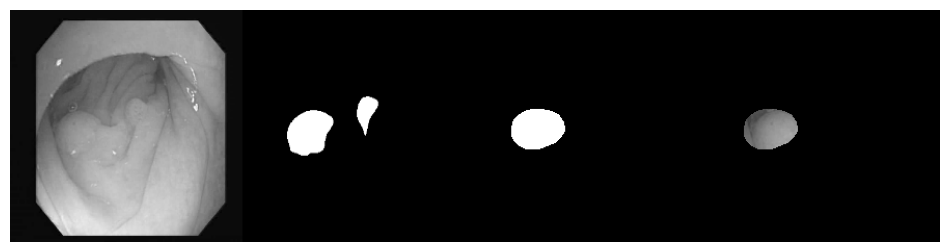

 Epoch: 45 of 100, Iter.: 46 of 46, Train Loss: 0.314674, IoU: 0.696917, Dice: 0.789451
 Epoch: 45 of 100, Iter.: 46 of 46, Valid Loss: 0.399803, IoU: 0.627256, Dice: 0.731920


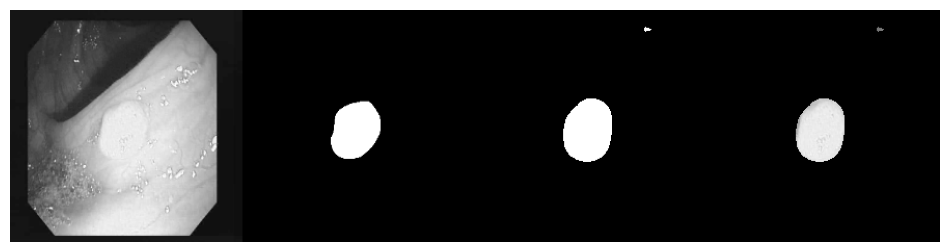

 Epoch: 46 of 100, Iter.: 46 of 46, Train Loss: 0.206895, IoU: 0.775784, Dice: 0.848872
 Epoch: 46 of 100, Iter.: 46 of 46, Valid Loss: 0.347690, IoU: 0.669062, Dice: 0.776133


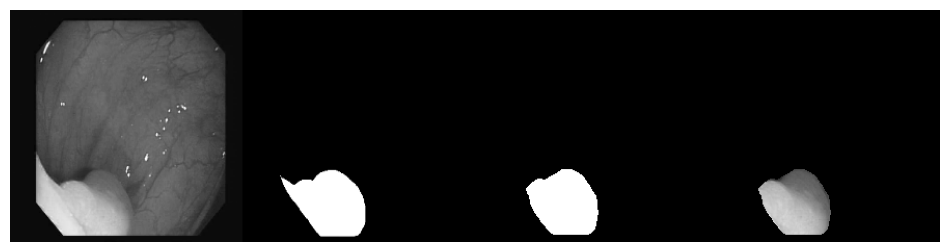

 Epoch: 47 of 100, Iter.: 46 of 46, Train Loss: 0.132353, IoU: 0.835905, Dice: 0.897260
 Epoch: 47 of 100, Iter.: 46 of 46, Valid Loss: 0.204784, IoU: 0.753621, Dice: 0.824394


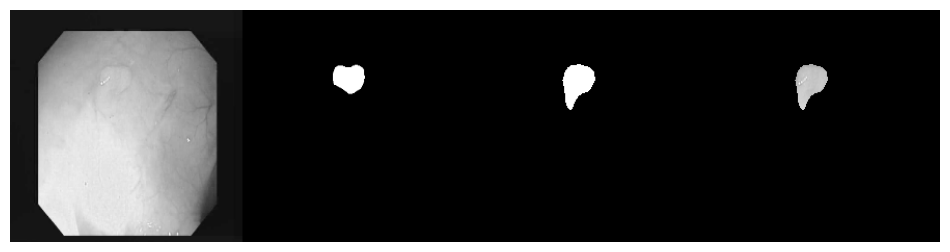

 Epoch: 48 of 100, Iter.: 46 of 46, Train Loss: 0.088568, IoU: 0.870572, Dice: 0.920109
 Epoch: 48 of 100, Iter.: 46 of 46, Valid Loss: 0.193273, IoU: 0.781348, Dice: 0.853482


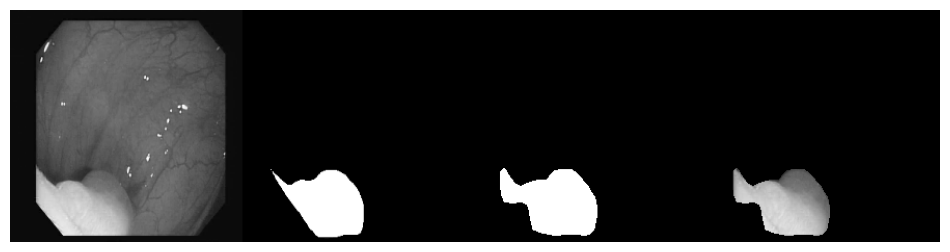

 Epoch: 49 of 100, Iter.: 46 of 46, Train Loss: 0.070777, IoU: 0.893134, Dice: 0.934461
 Epoch: 49 of 100, Iter.: 46 of 46, Valid Loss: 0.190500, IoU: 0.787706, Dice: 0.856547


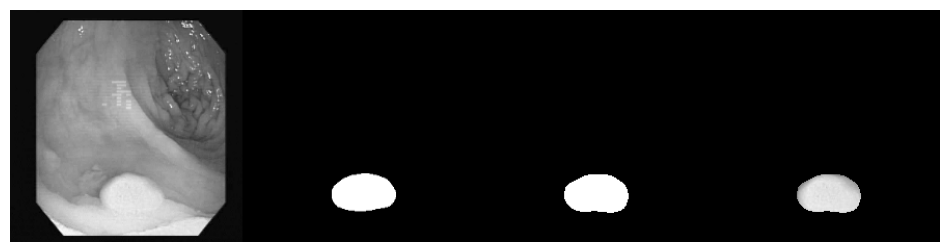

 Epoch: 50 of 100, Iter.: 46 of 46, Train Loss: 0.063382, IoU: 0.906384, Dice: 0.946008
 Epoch: 50 of 100, Iter.: 46 of 46, Valid Loss: 0.188456, IoU: 0.794688, Dice: 0.863982


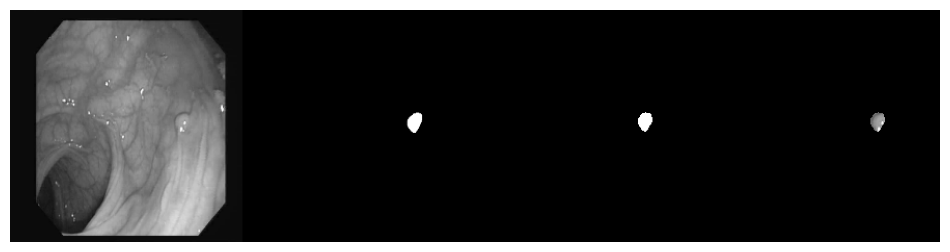

 Epoch: 51 of 100, Iter.: 46 of 46, Train Loss: 0.059409, IoU: 0.911266, Dice: 0.948709
 Epoch: 51 of 100, Iter.: 46 of 46, Valid Loss: 0.166461, IoU: 0.797801, Dice: 0.864926


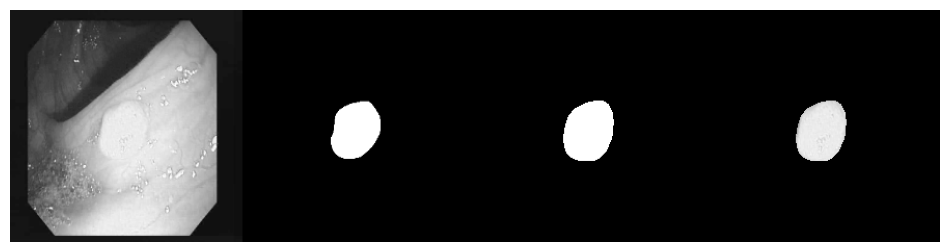

 Epoch: 52 of 100, Iter.: 46 of 46, Train Loss: 0.054250, IoU: 0.919057, Dice: 0.953370
 Epoch: 52 of 100, Iter.: 46 of 46, Valid Loss: 0.277409, IoU: 0.742368, Dice: 0.819160


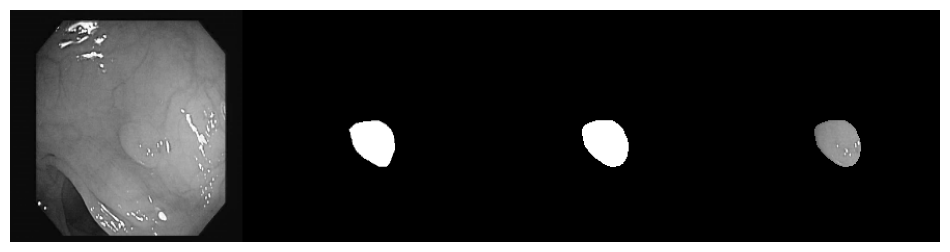

 Epoch: 53 of 100, Iter.: 46 of 46, Train Loss: 0.062292, IoU: 0.908114, Dice: 0.946509
 Epoch: 53 of 100, Iter.: 46 of 46, Valid Loss: 0.190412, IoU: 0.780067, Dice: 0.849782


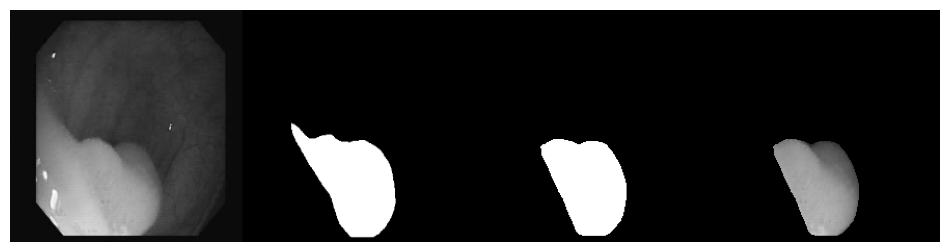

 Epoch: 54 of 100, Iter.: 46 of 46, Train Loss: 0.047159, IoU: 0.925861, Dice: 0.958248
 Epoch: 54 of 100, Iter.: 46 of 46, Valid Loss: 0.176243, IoU: 0.797422, Dice: 0.865171


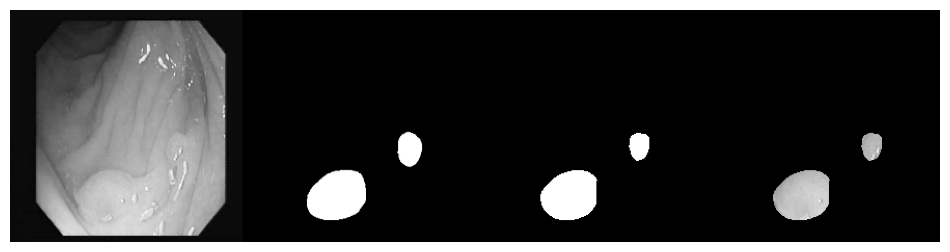

 Epoch: 55 of 100, Iter.: 46 of 46, Train Loss: 0.037834, IoU: 0.938420, Dice: 0.965923
 Epoch: 55 of 100, Iter.: 46 of 46, Valid Loss: 0.170357, IoU: 0.812275, Dice: 0.877688


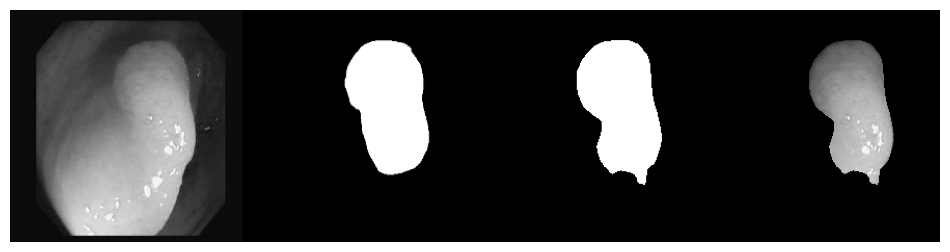

 Epoch: 56 of 100, Iter.: 46 of 46, Train Loss: 0.033348, IoU: 0.946721, Dice: 0.970605
 Epoch: 56 of 100, Iter.: 46 of 46, Valid Loss: 0.171813, IoU: 0.811566, Dice: 0.876846


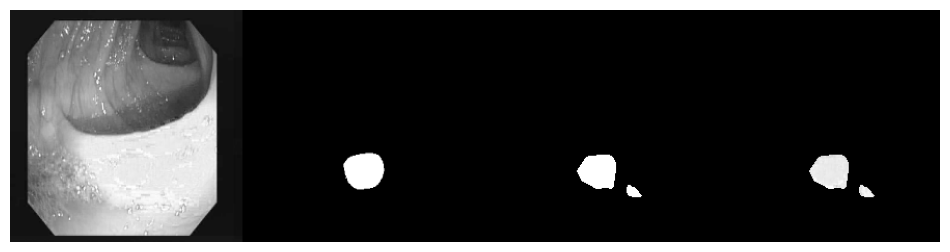

 Epoch: 57 of 100, Iter.: 46 of 46, Train Loss: 0.029605, IoU: 0.952698, Dice: 0.974088
 Epoch: 57 of 100, Iter.: 46 of 46, Valid Loss: 0.183815, IoU: 0.809943, Dice: 0.876395


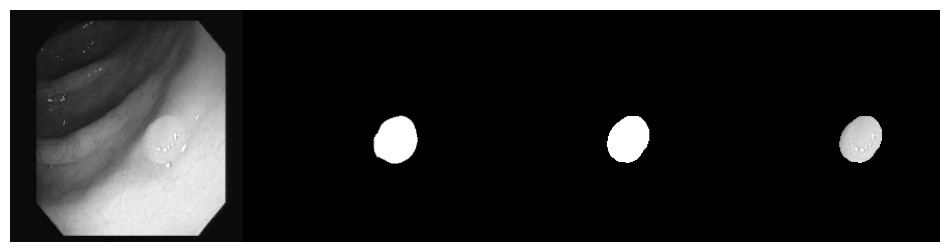

 Epoch: 58 of 100, Iter.: 46 of 46, Train Loss: 0.028248, IoU: 0.956099, Dice: 0.976360
 Epoch: 58 of 100, Iter.: 46 of 46, Valid Loss: 0.186235, IoU: 0.812616, Dice: 0.878531


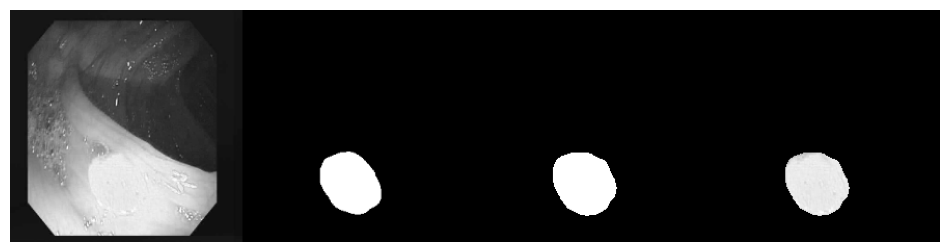

 Epoch: 59 of 100, Iter.: 46 of 46, Train Loss: 0.025713, IoU: 0.960084, Dice: 0.979259
 Epoch: 59 of 100, Iter.: 46 of 46, Valid Loss: 0.189114, IoU: 0.811203, Dice: 0.876340


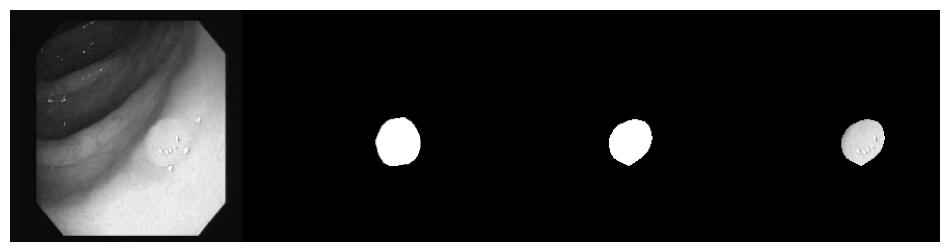

 Epoch: 60 of 100, Iter.: 46 of 46, Train Loss: 0.024967, IoU: 0.960702, Dice: 0.978497
 Epoch: 60 of 100, Iter.: 46 of 46, Valid Loss: 0.192602, IoU: 0.808742, Dice: 0.874911


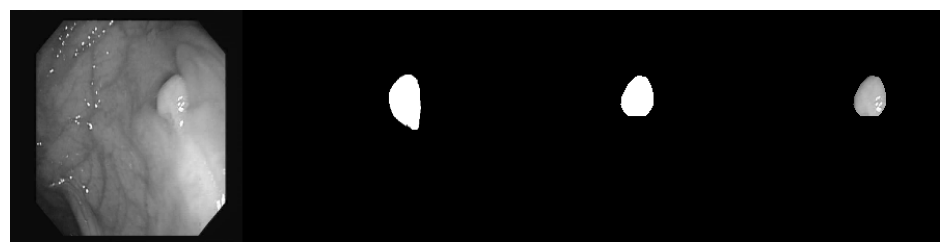

 Epoch: 61 of 100, Iter.: 46 of 46, Train Loss: 0.023555, IoU: 0.963868, Dice: 0.981317
 Epoch: 61 of 100, Iter.: 46 of 46, Valid Loss: 0.188424, IoU: 0.812301, Dice: 0.878366


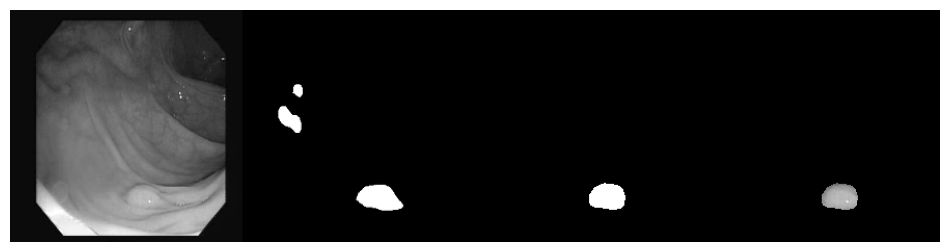

 Epoch: 62 of 100, Iter.: 46 of 46, Train Loss: 0.022725, IoU: 0.964114, Dice: 0.981465
 Epoch: 62 of 100, Iter.: 46 of 46, Valid Loss: 0.199742, IoU: 0.807425, Dice: 0.875137


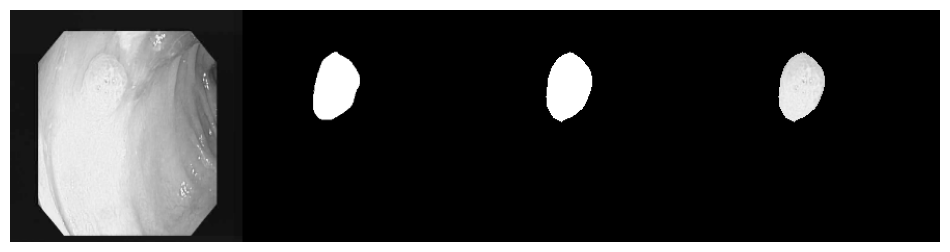


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 7min 54s, sys: 5min 24s, total: 13min 19s
Wall time: 9min 18s


In [15]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:41, Best_IOU:0.8205, Best_DiceScore:0.8855


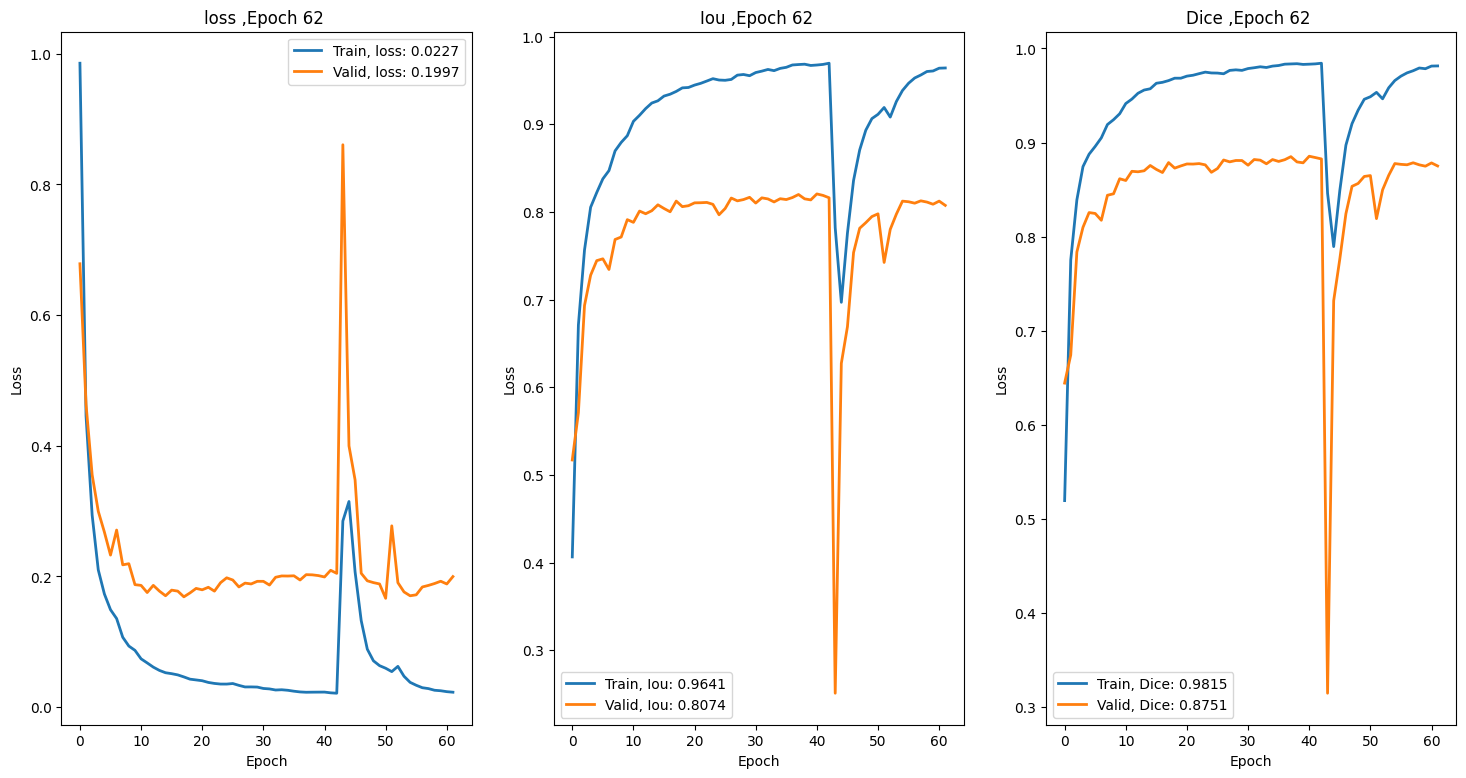

In [19]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()